<a href="https://colab.research.google.com/github/DangMinh21/CS114.L22.KHCL/blob/main/Stroke_Dettection/Stroke_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE

In [ ]:
def load_from_google(url):
  download_url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
  data = pd.read_csv(download_url)
  return data
  
train_url = 'https://drive.google.com/file/d/1iNpj_H3OiJLydq5wF_r75At9wZuULZ9e/view?usp=sharing'
test_url = 'https://drive.google.com/file/d/1Fuq6J2xHLVZ4BQnP22fxyPYHLh9Tvb4e/view?usp=sharing'
train_data = load_from_google(train_url)
test_data = load_from_google(test_url)

In [ ]:
train_data.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'blood', 'height', 'stroke'],
      dtype='object')

In [ ]:
  train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4000 non-null   int64  
 1   gender             4000 non-null   object 
 2   age                3893 non-null   float64
 3   hypertension       3770 non-null   float64
 4   heart_disease      3910 non-null   float64
 5   ever_married       4000 non-null   object 
 6   work_type          4000 non-null   object 
 7   Residence_type     4000 non-null   object 
 8   avg_glucose_level  3829 non-null   float64
 9   bmi                2884 non-null   float64
 10  smoking_status     4000 non-null   object 
 11  blood              3990 non-null   object 
 12  height             2928 non-null   float64
 13  stroke             4000 non-null   int64  
dtypes: float64(6), int64(2), object(6)
memory usage: 437.6+ KB


In [ ]:
train_data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,height,stroke
count,4000.000000,3893.000000,3770.000000,3910.000000,3829.000000,2884.000000,2928.000000,4000.000000
mean,36294.336250,43.071256,0.097613,0.055243,106.178062,28.887899,1.611831,0.032500
std,21213.704061,22.425944,0.296830,0.228483,45.048667,7.904179,0.149053,0.177346
min,77.000000,0.080000,0.000000,0.000000,55.220000,11.300000,0.910000,0.000000
25%,17294.000000,25.000000,0.000000,0.000000,77.500000,23.500000,1.520000,0.000000
50%,36688.500000,45.000000,0.000000,0.000000,92.110000,28.000000,1.630000,0.000000
75%,54425.000000,61.000000,0.000000,0.000000,114.090000,33.000000,1.722500,0.000000
max,72918.000000,82.000000,1.000000,1.000000,267.760000,97.600000,1.850000,1.000000


In [ ]:
train_data.isnull().sum()

id                      0
gender                  0
age                   107
hypertension          230
heart_disease          90
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level     171
bmi                  1116
smoking_status          0
blood                  10
height               1072
stroke                  0
dtype: int64

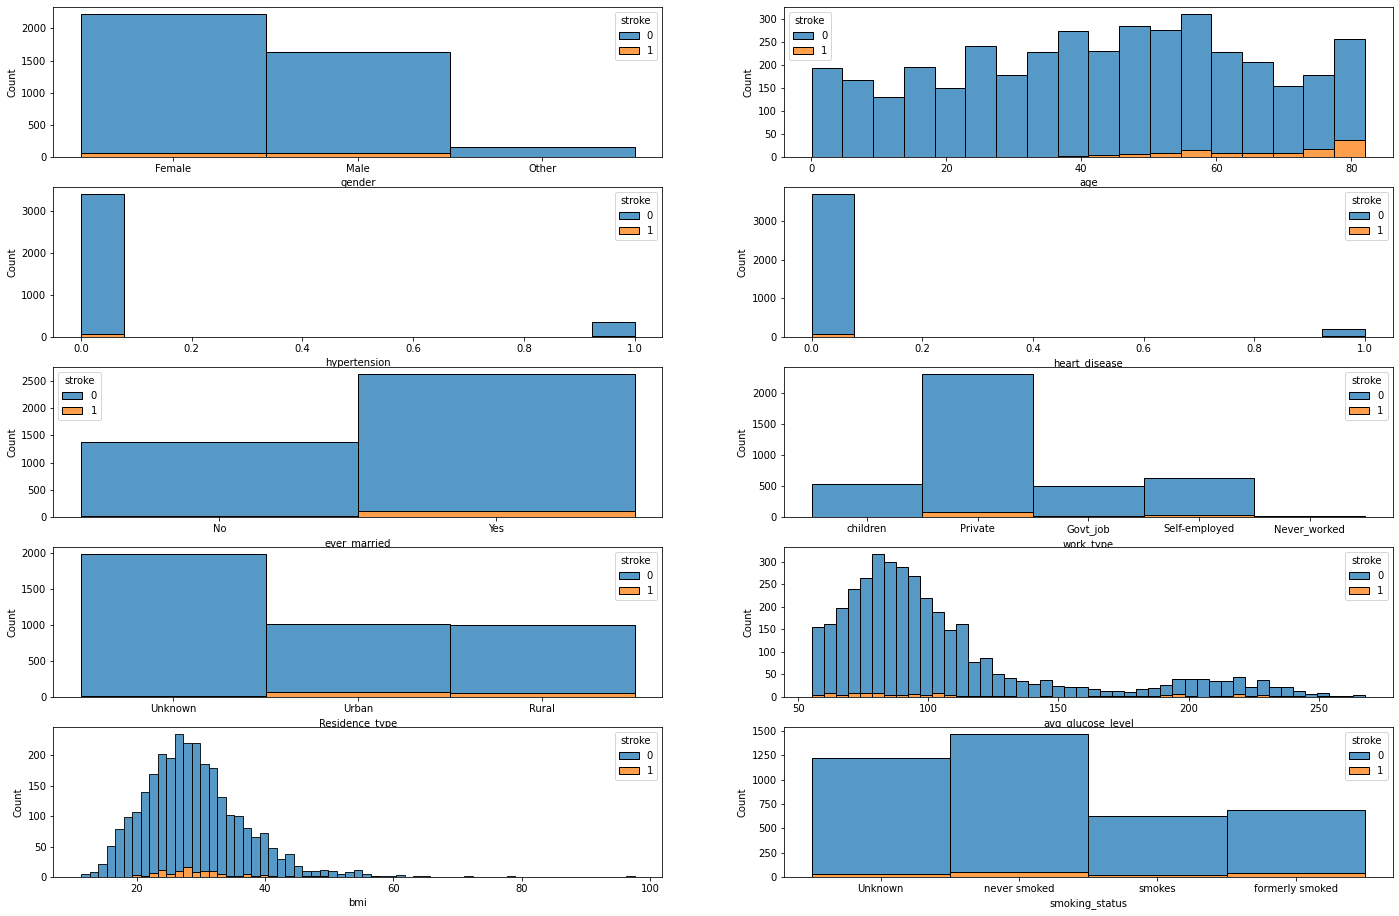

In [ ]:
def histplot(cols):
  fi, axs = plt.subplots(5, 2, figsize=(24, 16))
  k = 0
  for i in range(5):
    for j in range(2):
        sns.histplot(data = train_data, x = cols[k], hue='stroke', multiple='stack',ax=axs[i, j])
        k += 1
        if k == 10:
          break
histplot(train_data.columns[1:-3])

In [ ]:
print(train_data.columns)
num_cols = [col for col in train_data.columns if train_data[col].dtypes=='float64']
cat_cols = [col for col in train_data.columns if train_data[col].dtypes=='object']
print(num_cols)
print(cat_cols)

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'blood', 'height', 'stroke'],
      dtype='object')
['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'height']
['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'blood']


In [ ]:
# no label
def preprocessing(data):
  data.drop(columns=['id', 'Residence_type', 'gender', 'height'], inplace=True)

  data['age'] = data['age'].fillna(np.mean(data['age']))
  data['hypertension'] = data['hypertension'].fillna(1)
  data['heart_disease'] = data['heart_disease'].fillna(1)
  data['avg_glucose_level'] = data['avg_glucose_level'].fillna(np.mean(data['avg_glucose_level']))
  data['bmi'] = data['bmi'].fillna(np.mean(data['bmi']))

  data['work_type'] = data['work_type'].apply(lambda x: 1 if x=='Private' else 0)
  data["ever_married"] = data["ever_married"].apply(lambda x: 1 if x=="Yes" else 0)

  data_dummies = data[['work_type', 'smoking_status', 'blood']]
  data_dummies=pd.get_dummies(data_dummies)
  data.drop(columns=['work_type', 'smoking_status', 'blood'],inplace=True)
  data=data.merge(data_dummies,left_index=True, right_index=True,how='left')

  scaler = StandardScaler()
  data = scaler.fit_transform(data)
  return data


In [ ]:
x = train_data.drop(columns=['stroke'])
y = train_data.stroke

In [ ]:
x.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'blood', 'height'],
      dtype='object')

In [ ]:
process_data = preprocessing(x)

In [ ]:
x.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi'],
      dtype='object')

In [ ]:
process_data

array([[ 9.63616686e-16, -4.19260007e-01, -2.87814234e-01, ...,
        -7.92883658e-01, -5.11303946e-01,  2.03829320e+00],
       [ 5.39246789e-01, -4.19260007e-01, -2.87814234e-01, ...,
        -7.92883658e-01,  1.95578385e+00, -4.90606552e-01],
       [-4.84268434e-02, -4.19260007e-01, -2.87814234e-01, ...,
        -7.92883658e-01,  1.95578385e+00, -4.90606552e-01],
       ...,
       [ 6.29658117e-01,  2.38515476e+00, -2.87814234e-01, ...,
         1.26121908e+00, -5.11303946e-01, -4.90606552e-01],
       [ 8.71901488e-02, -4.19260007e-01, -2.87814234e-01, ...,
        -7.92883658e-01, -5.11303946e-01,  2.03829320e+00],
       [ 4.48835461e-01,  2.38515476e+00, -2.87814234e-01, ...,
        -7.92883658e-01, -5.11303946e-01,  2.03829320e+00]])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(process_data, y, train_size=0.8, random_state = 42)


In [ ]:
sm = SMOTE(ratio=0.25, random_state=42)
x_train_re, y_train_re = sm.fit_sample(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
x_train_re.shape

(3876, 15)

In [ ]:
model = LogisticRegression()
model.fit(x_train_re, y_train_re)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Testing Score:  0.93625
f1_score:  0.3855421686746988


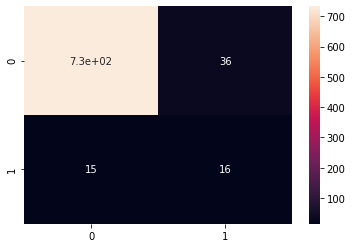

In [ ]:
prediction = model.predict(x_test)
score = model.score(x_test, y_test)
print('Testing Score: ',score)
f1_Score = f1_score(y_test, prediction)
print('f1_score: ', f1_Score)
cm = confusion_matrix(y_test,prediction)
sn.heatmap(cm, annot=True)
plt.show()

In [ ]:
# id = public_test['id']
# x_submit = preprocessing(public_test)
# y_submit = model.predict(x_submit)

# submit = pd.DataFrame({'id':id, 
#                        'stroke':y_submit})
# submit.to_csv('Submission.csv', index=False)
# !cp Submission.csv "drive/My Drive/Colab Notebooks"
# print("complete")